X_train shape: (60000, 784, 1)
X_test shape: (10000, 784, 1)
Y_train shape: (60000, 10)
Y_test shape: (10000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
phased_lstm_2 (PhasedLSTM)   (None, 32)                4448      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 4,778
Trainable params: 4,778
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
60000/60000 [==============================] - 1253s 21ms/step - loss: 1.3961 - acc: 0.5325
Epoch 2/2
60000/60000 [==============================] - 1275s 21ms/step - loss: 0.6948 - acc: 0.7883
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
____________________

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:84: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:93: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clear

Test score LSTM: 1.7412487159729004
Test score Phased LSTM: 0.5569833266735077


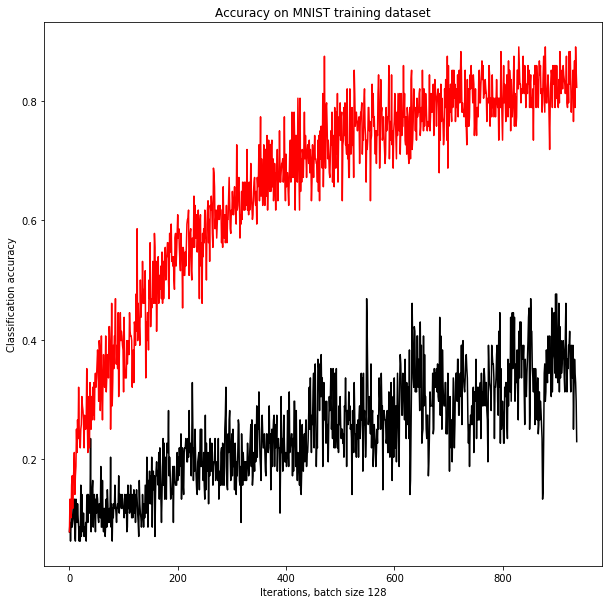

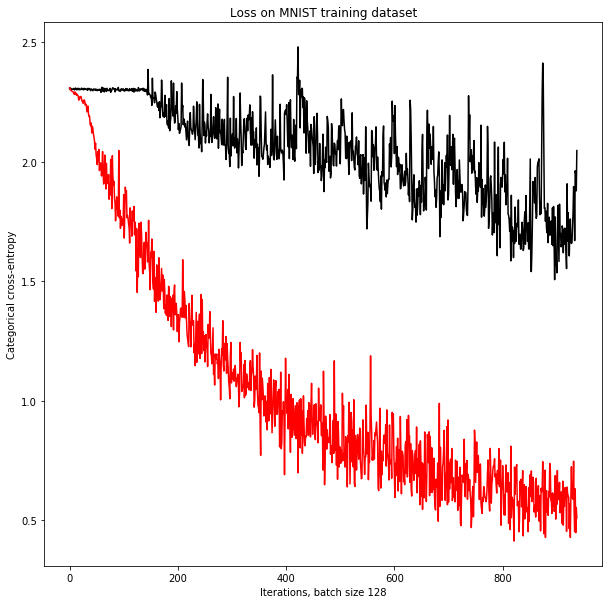

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from keras.datasets import mnist
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.utils import np_utils

from phased_lstm_keras.PhasedLSTM import PhasedLSTM as PLSTM


class AccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('acc'))


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


def main():
    batch_size = 128
    nb_classes = 10
    nb_epoch = 2

    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], img_rows * img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows * img_cols, 1)
    X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
    X_mean, X_std = np.mean(X_train), np.std(X_train)
    X_train, X_test = (X_train - X_mean) / X_std, (X_test - X_mean) / X_std
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    print('Y_train shape:', Y_train.shape)
    print('Y_test shape:', Y_test.shape)

    # LSTM with timegate
    model_PLSTM = Sequential()
    model_PLSTM.add(PLSTM(32, input_shape=(28 * 28, 1), implementation=2))
    model_PLSTM.add(Dense(10, activation='softmax'))
    model_PLSTM.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                        metrics=['accuracy'])
    model_PLSTM.summary()
    acc_PLSTM = AccHistory()
    loss_PLSTM = LossHistory()
    model_PLSTM.fit(X_train, Y_train, epochs=nb_epoch, batch_size=batch_size,
                    callbacks=[acc_PLSTM, loss_PLSTM])
    score_PLSTM = model_PLSTM.evaluate(X_test, Y_test, verbo se=0)

    # Vanilla LSTM
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(32, input_shape=(28 * 28, 1), implementation=2))
    model_LSTM.add(Dense(10, activation='softmax'))
    model_LSTM.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                       metrics=['accuracy'])
    model_LSTM.summary()
    acc_LSTM = AccHistory()
    loss_LSTM = LossHistory()
    model_LSTM.fit(X_train, Y_train, epochs=nb_epoch, batch_size=batch_size,
                   callbacks=[acc_LSTM, loss_LSTM])
    score_LSTM = model_LSTM.evaluate(X_test, Y_test, verbose=0)

    # plot results
    plt.figure(1, figsize=(10, 10))
    plt.title('Accuracy on MNIST training dataset')
    plt.xlabel('Iterations, batch size ' + str(batch_size))
    plt.ylabel('Classification accuracy')
    plt.plot(acc_LSTM.losses, color='k', label='LSTM')
    plt.hold(True)
    plt.plot(acc_PLSTM.losses, color='r', label='PLSTM')
    plt.savefig('mnist_plstm_lstm_comparison_acc.png', dpi=100)

    plt.figure(2, figsize=(10, 10))
    plt.title('Loss on MNIST training dataset')
    plt.xlabel('Iterations, batch size ' + str(batch_size))
    plt.ylabel('Categorical cross-entropy')
    plt.plot(loss_LSTM.losses, color='k', label='LSTM')
    plt.hold(True)
    plt.plot(loss_PLSTM.losses, color='r', label='PLSTM')
    plt.savefig('mnist_plstm_lstm_comparison_loss.png', dpi=100)

    # Compare test performance
    print('Test score LSTM:', score_LSTM[0])
    print('Test score Phased LSTM:', score_PLSTM[0])


if __name__ == "__main__":
    main()
